In [1]:
import os
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

from torchvision import transforms, models

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()

In [2]:
def display_pil_images(
    images, 
    labels,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
        
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        plt.title(labels[i], fontsize=label_font_size); 
        
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
DATA_DIR = '/home/alkhaldieid/repos/datasets/iciar/dataset1/train/'

IMAGE_SIZE = 224
SEED = 2000
BATCH_SIZE = 64
NUM_EPOCHS = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:

# for inceptionv3, xception 229, other models 224
IMAGE_SIZE = 224
SEED = 2000
BATCH_SIZE = 64
NUM_EPOCHS = 15

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
classes = os.listdir(DATA_DIR)
classes

['Benign', 'InSitu', 'Invasive', 'Normal']

In [6]:
samples_to_view = []
for label in classes:
    num_samples = len(os.listdir(os.path.join(DATA_DIR,label)))
    print(label + '\t' + str(num_samples))
    samples_to_view.append(random.choice(np.arange(num_samples)))

Benign	100
InSitu	100
Invasive	100
Normal	100


In [7]:
imgs = []
for idx, label in enumerate(classes):
    show_idx = samples_to_view[idx]
    file_name = os.listdir(os.path.join(DATA_DIR,label))[show_idx] 
    print(file_name)
    imgs.append(Image.open(os.path.join(DATA_DIR,label,file_name)))

b045.tif
is019.tif
iv075.tif
n006.tif


In [8]:
samples_to_view

[57, 6, 98, 60]

In [9]:
imgs_paths, labels = [], []
for label in classes:
    file_names = os.listdir(os.path.join(DATA_DIR,label))
    for file_name in file_names:
        imgs_paths.append(os.path.join(DATA_DIR,label,file_name))
        labels.append(label)

In [10]:
df = pd.DataFrame(data={'img_path': imgs_paths, 'label': labels})
df.head()

,img_path,label
0,/home/alkhaldieid/repos/datasets/iciar/dataset...,Benign
1,/home/alkhaldieid/repos/datasets/iciar/dataset...,Benign
2,/home/alkhaldieid/repos/datasets/iciar/dataset...,Benign
3,/home/alkhaldieid/repos/datasets/iciar/dataset...,Benign
4,/home/alkhaldieid/repos/datasets/iciar/dataset...,Benign


In [11]:
df.tail()

,img_path,label
395,/home/alkhaldieid/repos/datasets/iciar/dataset...,Normal
396,/home/alkhaldieid/repos/datasets/iciar/dataset...,Normal
397,/home/alkhaldieid/repos/datasets/iciar/dataset...,Normal
398,/home/alkhaldieid/repos/datasets/iciar/dataset...,Normal
399,/home/alkhaldieid/repos/datasets/iciar/dataset...,Normal


In [12]:
label_num = {}
for idx, item in enumerate(np.unique(df.label)):
    label_num[item] = idx 

In [13]:
label_num

{'Benign': 0, 'InSitu': 1, 'Invasive': 2, 'Normal': 3}

In [14]:
df['label']

0      Benign
1      Benign
2      Benign
3      Benign
4      Benign
        ...  
395    Normal
396    Normal
397    Normal
398    Normal
399    Normal
Name: label, Length: 400, dtype: object

In [15]:
df['label_num'] = df['label'].apply(lambda x: label_num[x])

In [16]:
df['label_num']

0      0
1      0
2      0
3      0
4      0
      ..
395    3
396    3
397    3
398    3
399    3
Name: label_num, Length: 400, dtype: int64

# PyTorch Dataset, Dataloaders and Transforms

In [17]:
class HistologyMnistDS(D.Dataset):
    def __init__(self, df, transforms, mode='train'):

        self.records = df.to_records(index=False)
        self.transforms = transforms
        self.mode = mode
        self.len = df.shape[0]
    
    @staticmethod
    def _load_image_pil(path):
        return Image.open(path)
        
    def __getitem__(self, index):
        path = self.records[index].img_path

        img = self._load_image_pil(path)
        
        if self.transforms:
            img = self.transforms(img)

        if self.mode in ['train', 'val', 'test']:
            return img, torch.from_numpy(np.array(self.records[index].label_num))
        else:
            return img

    def __len__(self):
        return self.len

In [18]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
train_df, tmp_df = train_test_split(df,
                                      test_size=0.2,  
                                      random_state=SEED,
                                      stratify=df['label'])

valid_df, test_df = train_test_split(tmp_df,
                                      test_size=0.8,  
                                      random_state=SEED,
                                      stratify=tmp_df['label'])

In [20]:
print("Train DF shape:", train_df.shape)
print("Valid DF shape:", valid_df.shape)
print("Test DF shape:", test_df.shape)

Train DF shape: (320, 3)
Valid DF shape: (16, 3)
Test DF shape: (64, 3)


In [21]:
ds_train = HistologyMnistDS(train_df, train_transforms)
ds_val = HistologyMnistDS(valid_df, val_transforms, mode='val')
ds_test = HistologyMnistDS(test_df, val_transforms, mode='test')

In [22]:
train_loader = D.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = D.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = D.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


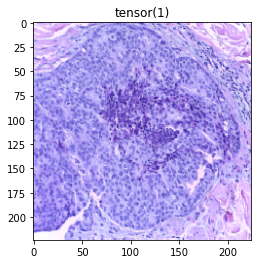

In [23]:
X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
plt.title(y_batch[0]);

In [24]:
model = models.resnet50(pretrained=False)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4))

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4))

In [26]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
filename = "best_resnet50_modelV5.pth.tar"
checkpoints_dir = 'kaggle/iciar/'

# Train Loop

In [28]:
import copy 
history_train_loss, history_val_loss = [], []
    
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
       
    best_loss = 10e10
    best_acc_score = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'train':
                history_train_loss.append(epoch_loss)
            else:
                history_val_loss.append(epoch_loss)
            
            if phase == 'val':
                def save_checkpoint(name):
                    checkpoint = {
                        'state_dict': best_model_wts
                    }

                    model_file_name = name + '.pth.tar'

                    model_file = checkpoints_dir + model_file_name

                    if not os.path.exists(checkpoints_dir):
                        os.mkdir(checkpoints_dir)

                    # saving best weights of model
                    torch.save(checkpoint, model_file)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving model for best loss")
                    save_checkpoint('best_model')
                
                if epoch_acc > best_acc_score:
                    best_acc_score = epoch_acc
                    
                print('Best_loss: {:.4f}'.format(best_loss))
                print('Best_acc_score: {:.4f}'.format(best_acc_score))

    return model

In [29]:
model = model.to(device)
train_model(model, loss, optimizer, scheduler, num_epochs=50);

Epoch 0/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]

train Loss: 1.5336 Acc: 0.2781



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 1.3861 Acc: 0.2500


Saving model for best loss
Best_loss: 1.3861
Best_acc_score: 0.2500
Epoch 1/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 1.3538 Acc: 0.3187



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 1.3929 Acc: 0.2500
Best_loss: 1.3861
Best_acc_score: 0.2500
Epoch 2/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

train Loss: 1.2193 Acc: 0.4344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 1.4128 Acc: 0.2500
Best_loss: 1.3861
Best_acc_score: 0.2500
Epoch 3/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]

train Loss: 1.1451 Acc: 0.4813



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 1.4170 Acc: 0.3750
Best_loss: 1.3861
Best_acc_score: 0.3750
Epoch 4/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 1.0453 Acc: 0.5688



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 1.0523 Acc: 0.5000


Saving model for best loss
Best_loss: 1.0523
Best_acc_score: 0.5000
Epoch 5/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]

train Loss: 0.9639 Acc: 0.5781



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 1.3767 Acc: 0.5000
Best_loss: 1.0523
Best_acc_score: 0.5000
Epoch 6/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.8935 Acc: 0.6125



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 1.1380 Acc: 0.5000
Best_loss: 1.0523
Best_acc_score: 0.5000
Epoch 7/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]

train Loss: 0.8645 Acc: 0.6406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.9355 Acc: 0.6250


Saving model for best loss
Best_loss: 0.9355
Best_acc_score: 0.6250
Epoch 8/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]

train Loss: 0.7914 Acc: 0.6969



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

val Loss: 0.8582 Acc: 0.7500


Saving model for best loss
Best_loss: 0.8582
Best_acc_score: 0.7500
Epoch 9/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.7829 Acc: 0.6656



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]

val Loss: 0.8431 Acc: 0.7500


Saving model for best loss
Best_loss: 0.8431
Best_acc_score: 0.7500
Epoch 10/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]

train Loss: 0.7140 Acc: 0.7250



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.8934 Acc: 0.6875
Best_loss: 0.8431
Best_acc_score: 0.7500
Epoch 11/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.7015 Acc: 0.7000



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.9317 Acc: 0.7500
Best_loss: 0.8431
Best_acc_score: 0.7500
Epoch 12/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.7288 Acc: 0.6813



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.8565 Acc: 0.6875
Best_loss: 0.8431
Best_acc_score: 0.7500
Epoch 13/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

train Loss: 0.7342 Acc: 0.6844



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.8427 Acc: 0.6875


Saving model for best loss
Best_loss: 0.8427
Best_acc_score: 0.7500
Epoch 14/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]

train Loss: 0.6610 Acc: 0.7219



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.9538 Acc: 0.6875
Best_loss: 0.8427
Best_acc_score: 0.7500
Epoch 15/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]

train Loss: 0.6302 Acc: 0.7406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.9487 Acc: 0.6875
Best_loss: 0.8427
Best_acc_score: 0.7500
Epoch 16/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

train Loss: 0.6495 Acc: 0.7312



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.7945 Acc: 0.6875


Saving model for best loss
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 17/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]

train Loss: 0.6332 Acc: 0.7344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.8771 Acc: 0.7500
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 18/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

train Loss: 0.6807 Acc: 0.7219



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.8991 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 19/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]

train Loss: 0.6397 Acc: 0.7125



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.9912 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 20/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

train Loss: 0.6709 Acc: 0.7188



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.8744 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 21/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6240 Acc: 0.7469



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.8853 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 22/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]

train Loss: 0.6235 Acc: 0.7438



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]

val Loss: 0.9648 Acc: 0.6250
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 23/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]

train Loss: 0.6244 Acc: 0.7375



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.9288 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 24/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.6337 Acc: 0.7531



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.9017 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 25/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.6107 Acc: 0.7469



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.8097 Acc: 0.6250
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 26/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6248 Acc: 0.7344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.8651 Acc: 0.7500
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 27/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]

train Loss: 0.6058 Acc: 0.7563



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 0.9496 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 28/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6614 Acc: 0.7156



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.8481 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 29/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6547 Acc: 0.7125



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.9446 Acc: 0.6875
Best_loss: 0.7945
Best_acc_score: 0.7500
Epoch 30/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]

train Loss: 0.6291 Acc: 0.7438



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

val Loss: 0.7779 Acc: 0.7500


Saving model for best loss
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 31/49:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6361 Acc: 0.7250



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.9027 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 32/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6251 Acc: 0.7594



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.8663 Acc: 0.7500
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 33/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]

train Loss: 0.6373 Acc: 0.7375



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.9448 Acc: 0.7500
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 34/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6579 Acc: 0.7063



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.8497 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 35/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]

train Loss: 0.6131 Acc: 0.7594



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.8001 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 36/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

train Loss: 0.6283 Acc: 0.7344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.8248 Acc: 0.7500
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 37/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

train Loss: 0.6209 Acc: 0.7563



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.8548 Acc: 0.6250
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 38/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6264 Acc: 0.7375



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.9241 Acc: 0.6250
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 39/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6262 Acc: 0.7438



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.9128 Acc: 0.6250
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 40/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6126 Acc: 0.7469



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.8669 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 41/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]

train Loss: 0.6159 Acc: 0.7656



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.8494 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 42/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6015 Acc: 0.7656



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.8481 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 43/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6143 Acc: 0.7438



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.9820 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 44/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6261 Acc: 0.7219



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 0.9741 Acc: 0.6250
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 45/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

train Loss: 0.6440 Acc: 0.7281



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.9222 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 46/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6347 Acc: 0.7250



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.8541 Acc: 0.7500
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 47/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

train Loss: 0.6163 Acc: 0.7500



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

val Loss: 0.8137 Acc: 0.6250
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 48/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.6270 Acc: 0.7375



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.8059 Acc: 0.7500
Best_loss: 0.7779
Best_acc_score: 0.7500
Epoch 49/49:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

train Loss: 0.6270 Acc: 0.7406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.9503 Acc: 0.6875
Best_loss: 0.7779
Best_acc_score: 0.7500


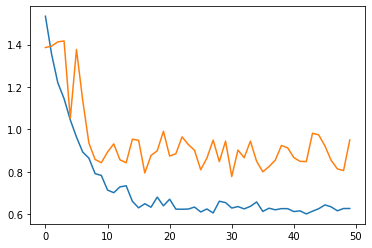

In [30]:
x = np.arange(50)
plt.plot(x, history_train_loss)
plt.plot(x, history_val_loss)

In [31]:
model.eval()

y_preds = []
for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    y_preds.append(preds.argmax(dim=1).data.cpu().numpy())
    
y_preds = np.concatenate(y_preds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


In [32]:
cm = confusion_matrix(test_df.label_num.values, y_preds)

Confusion matrix, without normalization
[[12  0  1  3]
 [ 1  9  3  3]
 [ 3  2 11  0]
 [ 3  1  0 12]]


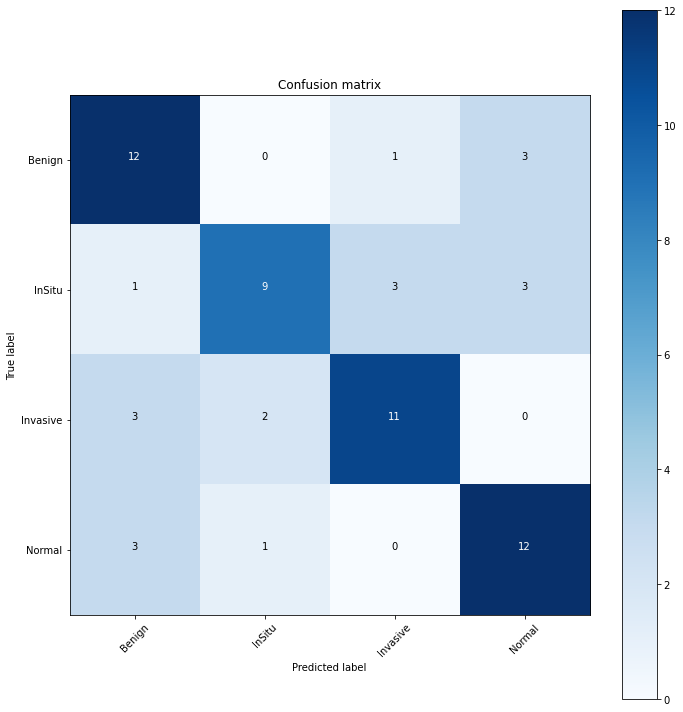

In [33]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, label_num)

In [34]:
print(classification_report(test_df.label_num.values, 
                            y_preds, 
                            target_names=list(label_num.keys())))

              precision    recall  f1-score   support

      Benign       0.63      0.75      0.69        16
      InSitu       0.75      0.56      0.64        16
    Invasive       0.73      0.69      0.71        16
      Normal       0.67      0.75      0.71        16

    accuracy                           0.69        64
   macro avg       0.70      0.69      0.69        64
weighted avg       0.70      0.69      0.69        64

